# Qredo tokenomics simulation - Ecosystem fund parameters

### June 2023

## 1. Imports

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load data

In [3]:
# load
df_file = os.path.join(outfolder, f"sample_by_ecosystem_params_and_scenarios.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["validator_profit"] = df["av_validator_reward"] * df["token_price"] - 200.0
df["untipped_fees_usd"] = (df["service_fees"] * (1-df["tipping_rate"]))/10**3
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released','day_burned',
             "total_staking_rewards", "validators_rewards","ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)

len(df)

10643400

In [4]:
df.columns

Index(['iteration', 'token_scenario', 'usage_scenario', 'staking_scenario',
       'tipping_rate', 'release_rate_max', 'circ_supply', 'day_burned',
       'day_vested', 'day_locked', 'day_released', 'staking_rewards_vested',
       'staking_rewards_ecosystem', 'total_staking_rewards',
       'validators_rewards', 'market_cap', 'n_validators', 'token_price',
       'day_burn_fees', 'day_service_fee_locked', 'ecosystem_fund',
       'staking_tvl', 'year_inflation', 'day_inflation', 'service_fees', 'apr',
       'tvl_rate', 'av_validator_reward', 'validator_profit',
       'untipped_fees_usd', 'date'],
      dtype='object')

In [5]:
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]
combined_df["combined_scenario"]=combined_df["staking_scenario"]

## 3. Ecosystem fund by scenario

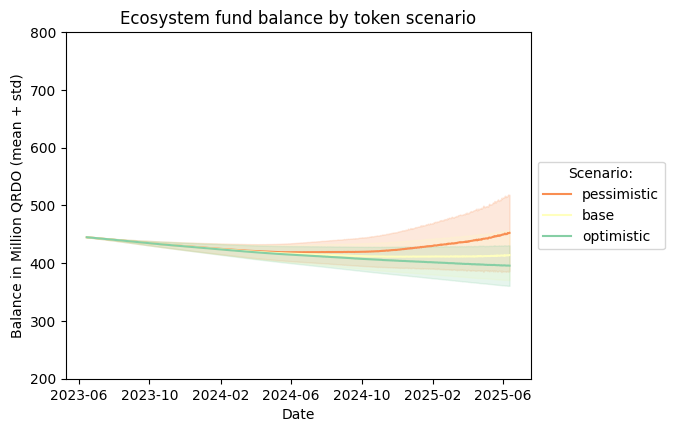

In [6]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(200,800)
plt.title("Ecosystem fund balance by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

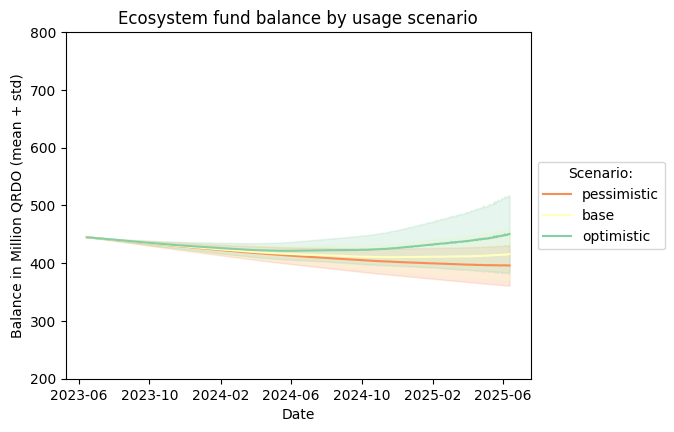

In [7]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(200,800)
plt.title("Ecosystem fund balance by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

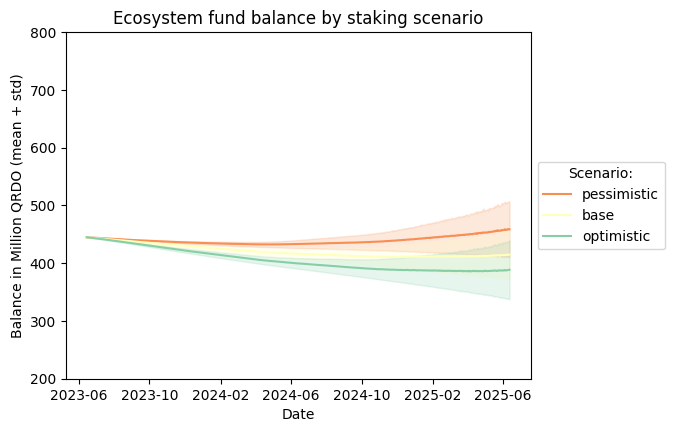

In [8]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(200,800)
plt.title("Ecosystem fund balance by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

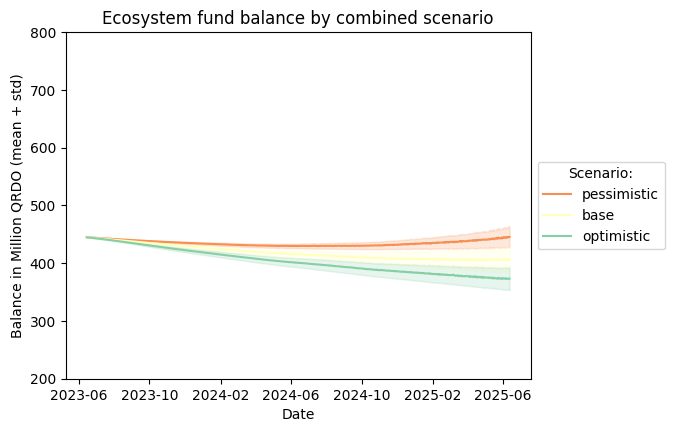

In [9]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="ecosystem_fund", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(200,800)
plt.title("Ecosystem fund balance by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

## 4. Ecosystem fund net flows

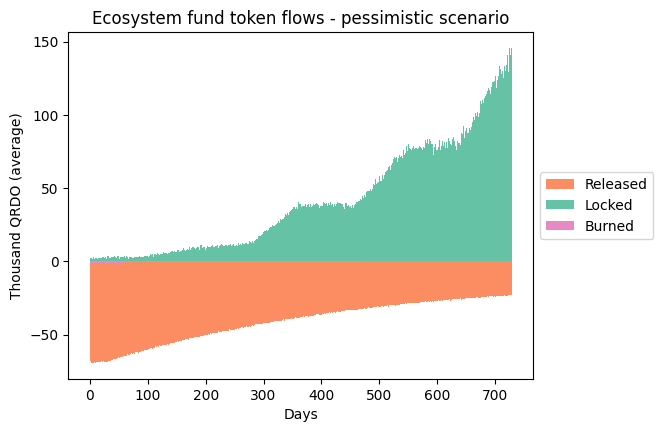

In [10]:
scenario = "pessimistic"
protocol_funded_rate = 0.8
# Data
cols = ['staking_rewards_ecosystem', 'day_service_fee_locked','protocol_burn_fees']
filter_df = combined_df[combined_df["token_scenario"]==scenario].copy()
filter_df['protocol_burn_fees'] = filter_df['day_burn_fees'] * protocol_funded_rate
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
burn = -temp_df["protocol_burn_fees"]
release = -temp_df['staking_rewards_ecosystem']+burn
lock = temp_df['day_service_fee_locked']

# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], release/10**3, label='Released', width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], lock/10**3, label="Locked", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], burn/10**3, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Thousand QRDO (average)")
plt.xlabel("Days")
plt.title(f"Ecosystem fund token flows - {scenario} scenario")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

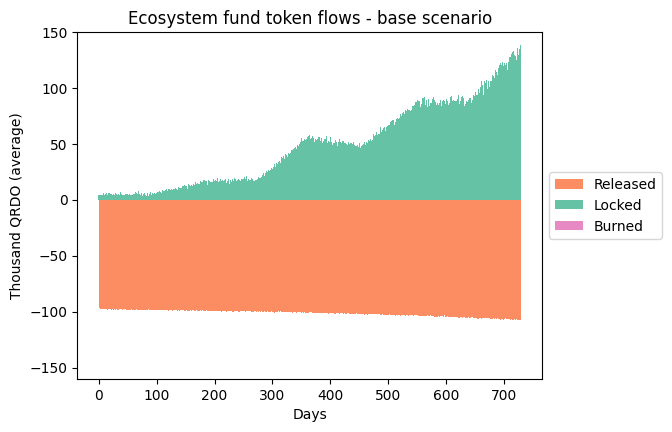

In [11]:
scenario = "base"
protocol_funded_rate = 0.5
# Data
cols = ['staking_rewards_ecosystem', 'day_service_fee_locked','protocol_burn_fees']
filter_df = combined_df[combined_df["token_scenario"]==scenario].copy()
filter_df['protocol_burn_fees'] = filter_df['day_burn_fees'] * protocol_funded_rate
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
burn = -temp_df["protocol_burn_fees"]
release = -temp_df['staking_rewards_ecosystem']+burn
lock = temp_df['day_service_fee_locked']

# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], release/10**3, label='Released', width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], lock/10**3, label="Locked", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], burn/10**3, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Thousand QRDO (average)")
plt.xlabel("Days")
plt.ylim(-160, 150)
plt.title(f"Ecosystem fund token flows - {scenario} scenario")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

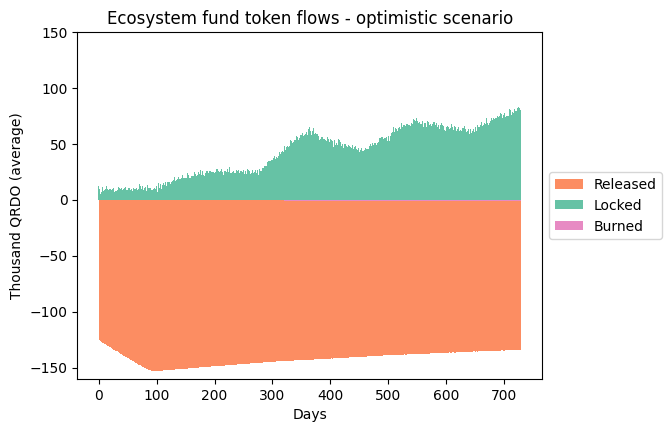

In [12]:
scenario = "optimistic"
protocol_funded_rate = 0.2
# Data
cols = ['staking_rewards_ecosystem', 'day_service_fee_locked','protocol_burn_fees']
filter_df = combined_df[combined_df["token_scenario"]==scenario].copy()
filter_df['protocol_burn_fees'] = filter_df['day_burn_fees'] * protocol_funded_rate
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
burn = -temp_df["protocol_burn_fees"]
release = -temp_df['staking_rewards_ecosystem']+burn
lock = temp_df['day_service_fee_locked']

# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], release/10**3, label='Released', width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], lock/10**3, label="Locked", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], burn/10**3, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Thousand QRDO (average)")
plt.xlabel("Days")
plt.ylim(-160, 150)
plt.title(f"Ecosystem fund token flows - {scenario} scenario")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 5. Parameter analysis - max release rate

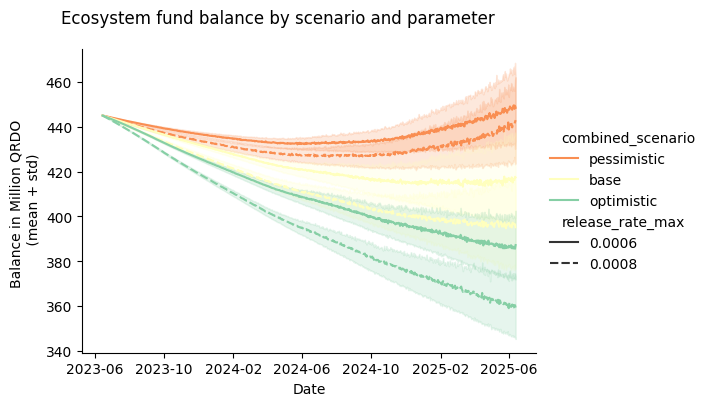

In [13]:
g = sns.relplot(data=combined_df, x="date", y="ecosystem_fund", style="release_rate_max", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Balance in Million QRDO \n (mean + std)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Ecosystem fund balance by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [14]:
temp_df = combined_df.groupby(["combined_scenario", "release_rate_max"])["ecosystem_fund"].mean()
temp_df

combined_scenario  release_rate_max
base               0.0006              423.938892
                   0.0008              413.843833
optimistic         0.0006              410.570434
                   0.0008              396.767429
pessimistic        0.0006              437.378183
                   0.0008              432.444345
Name: ecosystem_fund, dtype: float64

In [15]:
temp_df.reset_index().groupby("combined_scenario")["ecosystem_fund"].pct_change()

0         NaN
1   -0.023813
2         NaN
3   -0.033619
4         NaN
5   -0.011280
Name: ecosystem_fund, dtype: float64

## 6. Parameter analysis - tipping rate

**No impact:**
- av_validator_reward
- validator_profit
- apr

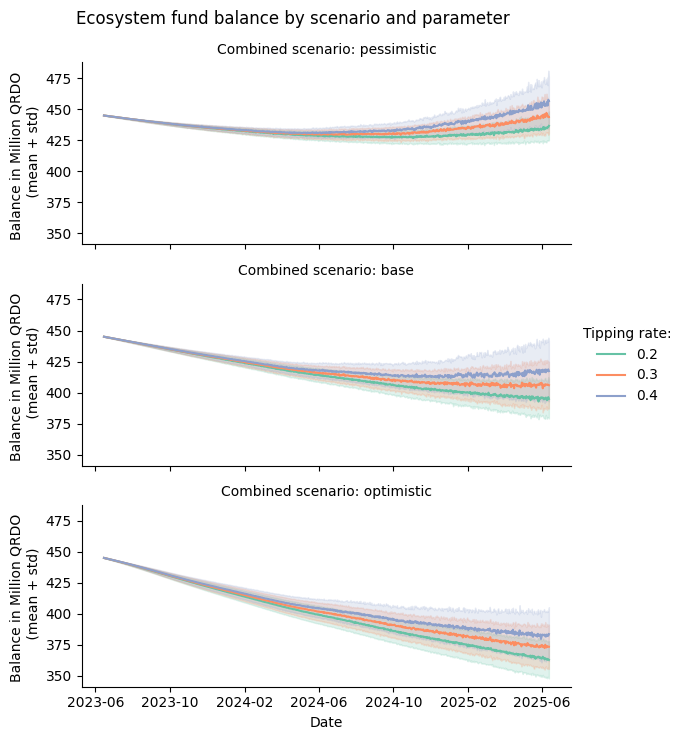

In [16]:
g = sns.relplot(data=combined_df, x="date", y="ecosystem_fund", hue="tipping_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Balance in Million QRDO \n (mean + std)")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Tipping rate:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Ecosystem fund balance by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [17]:
temp_df = combined_df.groupby(["iteration", "staking_scenario", "tipping_rate"])["ecosystem_fund"].mean().reset_index()
temp_df = temp_df[temp_df["iteration"]==729]

print(temp_df.groupby("staking_scenario")["ecosystem_fund"].diff())
print("")
temp_df

6561          NaN
6562    11.044358
6563    11.355964
6564          NaN
6565    10.558110
6566    10.183975
6567          NaN
6568     7.070058
6569    12.861411
Name: ecosystem_fund, dtype: float64



,iteration,staking_scenario,tipping_rate,ecosystem_fund
6561,729,base,0.2,394.890548
6562,729,base,0.3,405.934905
6563,729,base,0.4,417.290869
6564,729,optimistic,0.2,362.881247
6565,729,optimistic,0.3,373.439357
6566,729,optimistic,0.4,383.623332
6567,729,pessimistic,0.2,436.681509
6568,729,pessimistic,0.3,443.751567
6569,729,pessimistic,0.4,456.612978


86951.72854402069 103857.70932300233


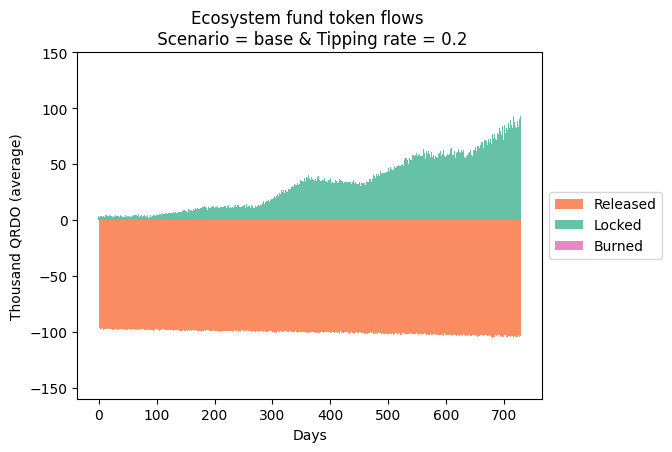

In [18]:
scenario = "base"
tipping_rate = 0.2
protocol_funded_rate = 0.5
# Data
cols = ['staking_rewards_ecosystem', 'day_service_fee_locked','protocol_burn_fees']
filter_df = combined_df[(combined_df["token_scenario"]==scenario) & (combined_df["tipping_rate"]==tipping_rate)].copy()
filter_df['protocol_burn_fees'] = filter_df['day_burn_fees'] * protocol_funded_rate
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
burn = -temp_df["protocol_burn_fees"]
release = -temp_df['staking_rewards_ecosystem']+burn
lock = temp_df['day_service_fee_locked']

print(lock.iloc[-1], temp_df['staking_rewards_ecosystem'].iloc[-1])
# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], release/10**3, label='Released', width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], lock/10**3, label="Locked", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], burn/10**3, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Thousand QRDO (average)")
plt.xlabel("Days")
plt.ylim(-160, 150)
plt.title(f"Ecosystem fund token flows \n Scenario = {scenario} & Tipping rate = {tipping_rate}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

131312.79300638006 107046.56899064663


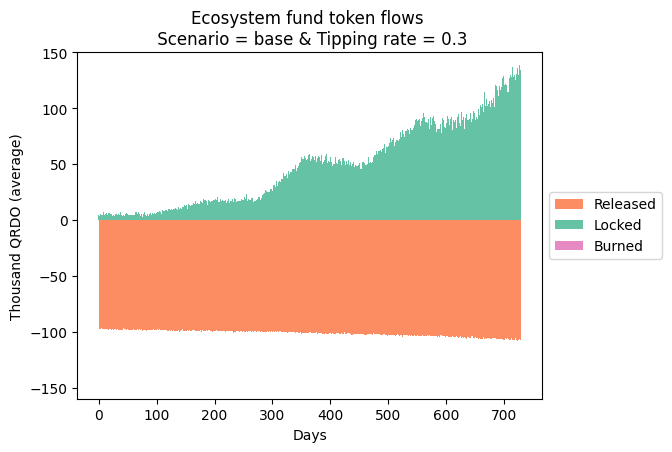

In [19]:
scenario = "base"
tipping_rate = 0.3
protocol_funded_rate = 0.5
# Data
cols = ['staking_rewards_ecosystem', 'day_service_fee_locked','protocol_burn_fees']
filter_df = combined_df[(combined_df["token_scenario"]==scenario) & (combined_df["tipping_rate"]==tipping_rate)].copy()
filter_df['protocol_burn_fees'] = filter_df['day_burn_fees'] * protocol_funded_rate
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
burn = -temp_df["protocol_burn_fees"]
release = -temp_df['staking_rewards_ecosystem']+burn
lock = temp_df['day_service_fee_locked']

print(lock.iloc[-1], temp_df['staking_rewards_ecosystem'].iloc[-1])
# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], release/10**3, label='Released', width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], lock/10**3, label="Locked", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], burn/10**3, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Thousand QRDO (average)")
plt.xlabel("Days")
plt.ylim(-160, 150)
plt.title(f"Ecosystem fund token flows \n Scenario = {scenario} & Tipping rate = {tipping_rate}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

174468.45408544445 109293.97824830137


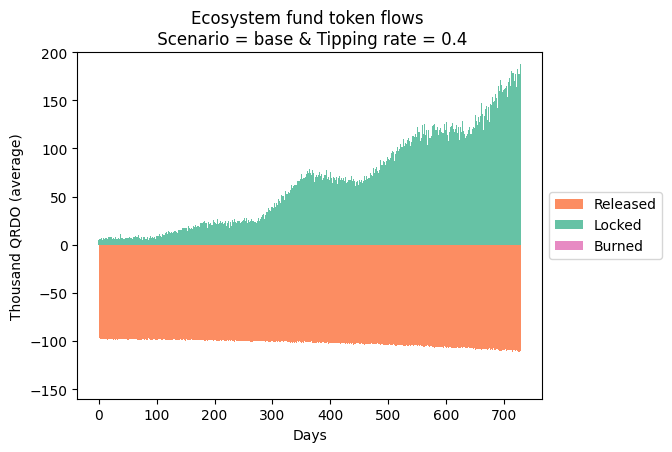

In [22]:
scenario = "base"
tipping_rate = 0.4
protocol_funded_rate = 0.5
# Data
cols = ['staking_rewards_ecosystem', 'day_service_fee_locked','protocol_burn_fees']
filter_df = combined_df[(combined_df["token_scenario"]==scenario) & (combined_df["tipping_rate"]==tipping_rate)].copy()
filter_df['protocol_burn_fees'] = filter_df['day_burn_fees'] * protocol_funded_rate
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
burn = -temp_df["protocol_burn_fees"]
release = -temp_df['staking_rewards_ecosystem']+burn
lock = temp_df['day_service_fee_locked']

print(lock.iloc[-1], temp_df['staking_rewards_ecosystem'].iloc[-1])
# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], release/10**3, label='Released', width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], lock/10**3, label="Locked", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], burn/10**3, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Thousand QRDO (average)")
plt.xlabel("Days")
plt.ylim(-160, 200)
plt.title(f"Ecosystem fund token flows \n Scenario = {scenario} & Tipping rate = {tipping_rate}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

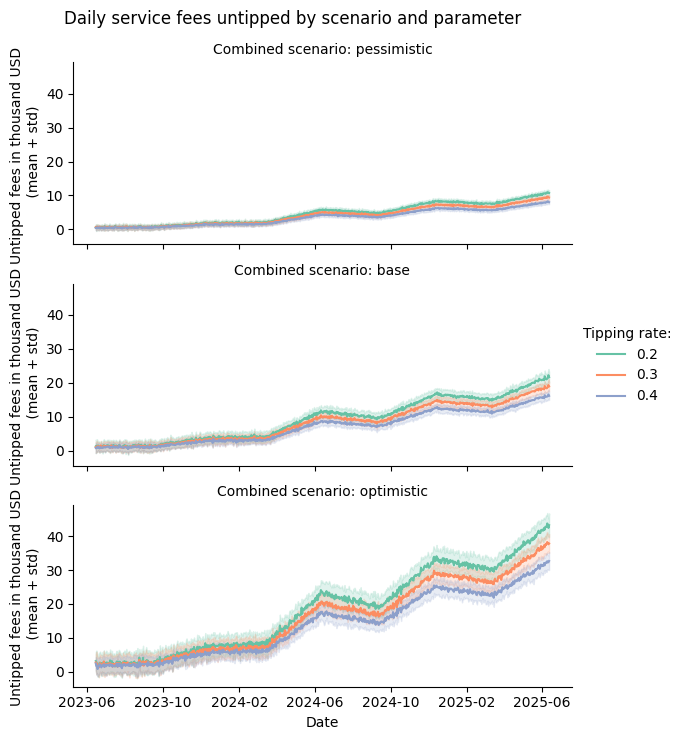

In [23]:
g = sns.relplot(data=combined_df, x="date", y="untipped_fees_usd", hue="tipping_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Untipped fees in thousand USD \n (mean + std)")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Tipping rate:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Daily service fees untipped by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [24]:
temp_df = combined_df.groupby(["iteration", "staking_scenario", "tipping_rate"])["untipped_fees_usd"].mean().reset_index()
temp_df = temp_df.groupby(["staking_scenario", "tipping_rate"])["untipped_fees_usd"].sum().reset_index()

print(temp_df.groupby("staking_scenario")["untipped_fees_usd"].diff())
print("")
temp_df

0            NaN
1    -840.003751
2    -833.814988
3            NaN
4   -1677.655326
5   -1668.110924
6            NaN
7    -418.232720
8    -422.227196
Name: untipped_fees_usd, dtype: float64



,staking_scenario,tipping_rate,untipped_fees_usd
0,base,0.2,6703.361745
1,base,0.3,5863.357994
2,base,0.4,5029.543005
3,optimistic,0.2,13397.974479
4,optimistic,0.3,11720.319153
5,optimistic,0.4,10052.208229
6,pessimistic,0.2,3355.682286
7,pessimistic,0.3,2937.449566
8,pessimistic,0.4,2515.222370
